In [1]:
%matplotlib inline
import hashlib
import matplotlib.pyplot as plt
import numpy as np

from disp import set_font_size


D = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

N = 1000
Z = 16
GAM = 1

M = len(D)

def hamming(x_k, x_l):
    return np.mean(x_k != x_l)

In [2]:
class Encoder(object):
    
    
    def __init__(self, seed, d, n, z, gam):
        self.seed = seed
        self.d = d
        self.m = len(d)
        
        self.n = n
        self.z = z
        self.gam = gam
        
        # sample basis and mask function aux var
        np.random.seed(seed)
        self.x_star = np.random.randint(0, z, n)
        self.xs = [np.random.randint(0, z, n) for i in range (self.m)]
        
        self.seed_offset = np.random.randint(0, 2**32-1)
    
    
    def veil(self, x_k, x_l):
        # get unique RNG seed from x_k and x_l
        str_repr = ''.join(x_k.astype(str)) + ''.join(x_l.astype(str))
        rng_seed = int(hashlib.sha256(str_repr.encode('utf-8')).hexdigest(), 16)  % 10**9
        
        np.random.seed((rng_seed + self.seed_offset)%(2**32))
        
        return np.random.rand(len(x_k))
    
    
    def weave(self, x_k, x_l, t):
        mask = self.veil(x_k, x_l) < 1/(t+1)**self.gam
        u = x_k.copy()
        u[mask] = x_l[mask]
        return u
    
    
    def encode(self, s):
        y = self.x_star.copy()
        
        for t_, a in enumerate(s):
            t = t_+1
            idx = self.d.index(a)
            y = self.weave(y, self.xs[idx], t)
            
        return y
    
    
    def smty_seq_sbl(self, y, s_i):
        if self.gam != 1:
            raise NotImplementedError
        
        n_i = np.sum(np.array([y_ for y_ in y], dtype='<U1') == s_i)
        l = len(y)
        
        q = n_i/(l+1) + (1/self.z) * (l + 1 - n_i)/(l + 1)

        return q, q*(1-q)/self.n
    
    
    def smty_seq_seq(self, y, y_):
        if self.gam != 1:
            raise NotImplementedError
        
        # get seq lens and shared starting subseq len (t)
        l = len(y)
        l_ = len(y_)
        t = 0
        for s, s_ in zip(y, y_):
            if s == s_:
                t += 1
            else:
                break
        
        assert np.all(y[:t] == y_[:t])
        
        # convert seqs to arrays
        y = np.array([yy for yy in y], dtype='<U1')
        y_ = np.array([yy for yy in y_], dtype='<U1')

        # get symbol count vecs
        n_u = [np.sum(y[:t] == self.d[i]) for i in range(self.m)]
        n_v = [np.sum(y[t:] == self.d[i]) for i in range(self.m)]
        n_v_ = [np.sum(y_[t:] == self.d[i]) for i in range(self.m)]
        
        # calc case probabilites from ms section 4.2
        p_1 = (t+1)**2 / ((l+1)*(l_+1))
        
        p_2 = 1 / ((l+1)*(l_+1)) * \
            ( np.dot(n_v, n_v_) + ((l-t)*(l_-t) - np.dot(n_v, n_v_)) * (1/self.z) )
        
        p_3 = 1 / ((l+1)*(l_+1)) * \
            ( np.dot(n_u, n_v_) + ((t+1)*(l_-t) - np.dot(n_u, n_v_)) * (1/self.z) )
        
        p_4 = 1 / ((l+1)*(l_+1)) * \
            ( np.dot(n_v, n_u) + ((l-t)*(t+1) - np.dot(n_v, n_u)) * (1/self.z) )
        
        # sum case probabilities
        q = p_1 + p_2 + p_3 + p_4
        
        return q, q*(1-q)/self.n
    
    
class Decoder(object):
    
    def __init__(self, encoder):
        self.e = encoder
        
    
    def decode(self, y, l, return_dst=False, force_decode=None):
        
        # get set of elements in sequence
        min_idxs = np.argsort([hamming(x, y) for x in self.e.xs])
        vs = [self.e.xs[idx] for idx in min_idxs]
        
        # reconstruct sequence
        y_star = self.e.x_star.copy()
        s_hat = ''
        dst = [hamming(y_star, y)]
        
        for t in range(1, l+1):
            
            us = [self.e.weave(y_star, v, t) for v in vs]
            j = np.argmin([hamming(u, y) for u in us])

            if force_decode is not None and len(force_decode) >= t:
                next_sym = force_decode[t-1]
                next_x = self.e.xs[self.d.index(next_sym)]
            else:
                next_sym = self.e.d[min_idxs[j]]
                next_x = vs[j]

            s_hat += next_sym
            y_star = self.e.weave(y_star, next_x, t)
            dst.append(hamming(y_star, y))

        if not all(y_star == y):
            print('Default reconstruction failed.')

        if not return_dst:
            return s_hat
        else:
            return s_hat, np.array(dst)

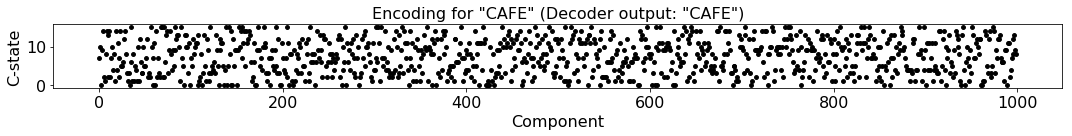

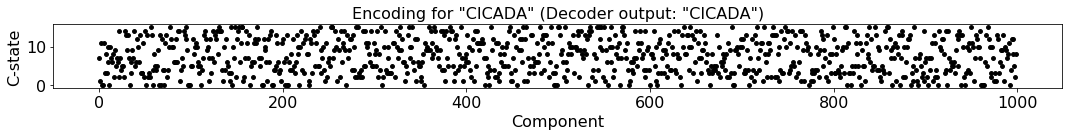

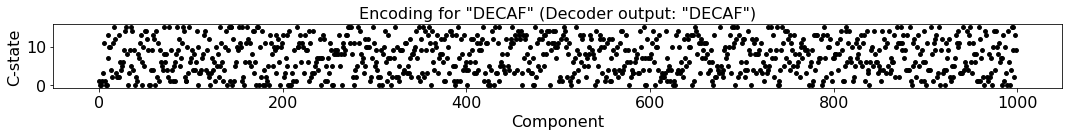

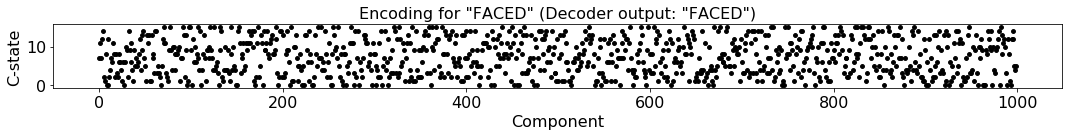

In [3]:
encoder = Encoder(0, D, N, Z, GAM)
decoder = Decoder(encoder)

for y in ['CAFE', 'CICADA', 'DECAF', 'FACED']:

    x = encoder.encode(y)
    fig, ax = plt.subplots(1, 1, figsize=(15, 2), tight_layout=True)
    ax.scatter(range(len(x)), x, s=15, c='k')
    ax.set_xlabel('Component')
    ax.set_ylabel('C-state')
    ax.set_title('Encoding for "{}" (Decoder output: "{}")'.format(y, decoder.decode(x, len(y))))
    set_font_size(ax, 16)

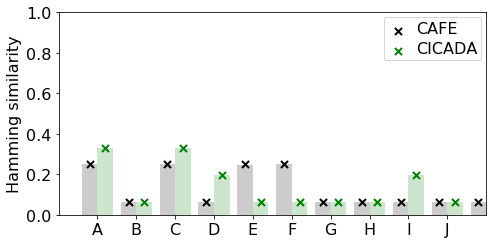

In [4]:
# plot expected and true seq-symbol similarities for two diff seqs
N_TRIALS = 100
X_LIM = (-1, 10)

fig, ax = plt.subplots(1, 1, figsize=(7, 3.5), tight_layout=True)
hs = []

for y, c, x_off in zip(['CAFE', 'CICADA'], ['k', 'g'], [-.2, .2]):
    # generate simulated similarities
    smtys = np.nan * np.zeros((N_TRIALS, len(D)))
    
    for seed in range(N_TRIALS):
        encoder = Encoder(seed, D, N, Z, GAM)
        x = encoder.encode(y)
        smtys[seed] = [1 - hamming(x, encoder.xs[i]) for i in range(encoder.m)]
    
    plt.bar(np.arange(len(D)) + x_off, smtys.mean(0), width=.4, color=c, alpha=.2)
    
    # plot exact similarities
    smty_exact = [encoder.smty_seq_sbl(y, s_)[0] for s_ in D]
    h = ax.scatter(np.arange(len(smty_exact)) + x_off, smty_exact, c=c, s=50, marker='x', lw=2, label=y)
    hs.append(h)

ax.set_xlim(X_LIM)
ax.set_ylim(0, 1)

ax.set_xticks(range(X_LIM[1]))
ax.set_xticklabels(D[:X_LIM[1]])
ax.set_ylabel('Hamming similarity')

ax.legend(handles=hs)

set_font_size(ax, 16)

In [5]:
# plot expected and true seq-seq similarities
N_TRIALS = 100
y = 'COFFEE'
y_ = 'COVFEFE'

smty = []

for seed in range(N_TRIALS):
    encoder = Encoder(seed, D, N, Z, GAM)
    x = encoder.encode(y)
    x_ = encoder.encode(y_)
    
    smty.append(1 - hamming(x, x_))
    
print(encoder.smty_seq_seq(y, y_)[0])
print(np.mean(smty))

0.3470982142857143
0.34835
